# Widen display (Convenience)

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Method 1: Hamiltonian filling in $S^z$ basis

In [56]:
import numpy as np
from   scipy.sparse import csr_matrix
import scipy as sp
from   scipy.sparse.linalg import eigsh
import itertools as it
from scipy.optimize import curve_fit



def basis_no(i, L):
    return sum((2**j) * ((i[j] + 1) // 2) for j in range(L))


def action(ii, Hbond, theta, bnd):
    i, j = Hbond
    state_list = []
    coef_list = []
    
    # Heisenberg AFM only model
    # diagonal
    de = 0.25 * ((ii[i] * ii[j])-1)
    if abs(de) > 1e-6:
        coef_list.append(de)
        state_list.append(ii)

    # off-diagonal
    if (ii[i]*ii[j] == -1):
        jj = list(ii)
        jj[i] = -ii[i] # flip site i
        jj[j] = -ii[j] # flip site j
        jj = tuple(jj)
        if bnd: coef_list.append(0.5  * np.cos(theta))
        else: coef_list.append(0.5)
        #coef_list.append(0.5)
        state_list.append(jj)

    return state_list, coef_list   



# Spin-1/2
def Bilayer_Bi_QQ_JH(Lx, Ly, JH, theta, xbonds, ybonds):

    L = Lx*Ly
    data = []
    rows = []
    cols = []

    for ii in it.product([-1, 1], repeat=L): 

        # Heisenberg interactions
        if abs(JH) > 1e-6:
            for bond in xbonds:
                state_list, coef_list = action(ii, bond, theta, True)
                for jc, jj in enumerate(state_list):
                    data.append(JH * coef_list[jc])
                    rows.append(basis_no(ii, L))
                    cols.append(basis_no(jj, L)) 
                    
        # Heisenberg interactions
        if abs(JH) > 1e-6:
            for bond in ybonds:
                state_list, coef_list = action(ii, bond, theta, False)
                for jc, jj in enumerate(state_list):
                    data.append(JH * coef_list[jc])
                    rows.append(basis_no(ii, L))
                    cols.append(basis_no(jj, L))                     

    Hsp = csr_matrix((data, (rows, cols)), shape=(2**L, 2**L), dtype=np.float64)     
    return Hsp 



def bond_list(Lx, Ly):
    xbondlist = []
    ybondlist = []
    for i in range(0,Lx*Ly):
        x = i // Lx
        xbondlist.append([i, Lx*x+(i+1)%Lx])
        if Ly > 1: ybondlist.append([i, (i+Lx)%(Lx*Ly)])           
    return xbondlist, ybondlist 

In [57]:
def twist_function(theta, a, b):
    return a * theta**2 + b

def calculate_spin_stiffness(theta_values, energy_values):
    # Numerical differentiation to estimate the second derivative
    dtheta = theta_values[1] - theta_values[0]
    # Fit the energy/free energy curve to a quadratic form
    popt, pconv = curve_fit(twist_function, theta_values, energy_values, p0=(0.5, -3.0))
    
    # The coefficient of the quadratic term is the spin stiffness
    rho_s = popt[0] / 2.0
    rho_s_err = pconv[0][0]
    return rho_s, rho_s_err

## 4 site chain

 Beta | energy | rho  =   40 | -0.74999999999999988583 | 0.08313413173190763


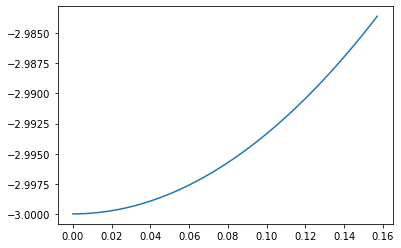

In [71]:
import matplotlib.pyplot as plt

Lx = 4
Ly = 1
JH = 1.
beta = 40


xbonds, ybonds = bond_list(Lx, Ly)           # 2D PBC lattice

#print(xbonds, ybonds)

twist_angles = np.linspace(0, np.pi/20, 50)

elist = [];
zlist = [];
Flist = [];
for twist in twist_angles:
    H = Bilayer_Bi_QQ_JH(Lx, Ly, JH, twist, xbonds, ybonds)#.toarray()
    W = eigsh(H, k=15, which='SA',return_eigenvectors=False)
    z = np.sum(np.exp(-np.float128(beta * W)))
    e = np.sum(W*np.exp(-np.float128(beta * W)))/z
    f = -np.log(z)/beta 
    elist.append(e)
    zlist.append(z)
    Flist.append(f)

    
plt.plot(twist_angles, Flist)
rho, rho_err = calculate_spin_stiffness(twist_angles,Flist)
#rho = (Flist[1] - Flist[0])/(twist_angles[1]-twist_angles[0])**2/Lx/2    #for i, twist in enumerate(twist_angles):    
print(" Beta | energy | rho  =  ", beta, "|", elist[0]/Lx/Ly, "|", rho/Lx/Ly)

## 4x2 lattice

 Beta | energy | rho  =   30 | -1.3667915636316974031 | 0.039981987470267995


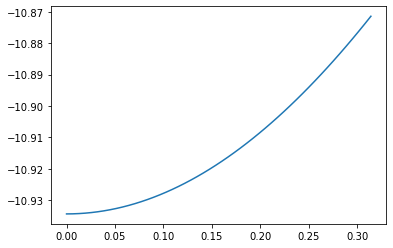

In [72]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

Lx = 4
Ly = 2
JH = 1.
beta = 30


xbonds, ybonds = bond_list(Lx, Ly)           # 2D PBC lattice

#print(xbonds, ybonds)

twist_angles = np.linspace(0, np.pi/10, 50)

elist = [];
zlist = [];
Flist = [];
for twist in twist_angles:
    H = Bilayer_Bi_QQ_JH(Lx, Ly, JH, twist, xbonds, ybonds)#.toarray()
    W = eigsh(H, k=15, which='SA',return_eigenvectors=False)
    z = np.sum(np.exp(-np.float128(beta * W)))
    e = np.sum(W*np.exp(-np.float128(beta * W)))/z
    f = -np.log(z)/beta
    elist.append(e)
    zlist.append(z)
    Flist.append(f)

    
plt.plot(twist_angles, Flist)
rho, rho_err = calculate_spin_stiffness(twist_angles,Flist)
#rho = (Flist[1] - Flist[0])/(twist_angles[1]-twist_angles[0])**2/Lx/2    #for i, twist in enumerate(twist_angles):    
print(" Beta | energy | rho  =  ", beta, "|", elist[0]/Lx/Ly, "|", rho/Lx/Ly)

# Method 2: Tensor products of spins

## 4 site chain


In [17]:
import numpy as np

sx = ([[0, 1], [1, 0]])
sy = ([[0, -1j], [1j, 0]])
sz = ([[1, 0], [0, -1]])
I = np.eye(2**(1)) 

sxsx = np.kron(sx, sx)
sysy = np.kron(sy, sy)
szsz = np.kron(sz, sz)
II = np.kron(I,I)

Isx = np.kron(I,sx)
sxI = np.kron(sx,I)

Isy = np.kron(I,sy)
syI = np.kron(sy,I)


Isz = np.kron(I,sz)
szI = np.kron(sz,I)

In [74]:

def Ham(J, theta):
    f = np.cos(theta)
    H = J*(1/4)*(np.kron(sxsx, II) + np.kron(sysy, II) + np.kron(szsz, II)) # 0,1
    H += J*(1/4)*(np.kron(Isx, sxI) + np.kron(Isy, syI) + np.kron(Isz, szI)) # 1,2
    H += J*(1/4)*(np.kron(II, sxsx) + np.kron(II, sysy) + np.kron(II, szsz)) # 2,3
    H += J*(1/4)*(f*np.kron(sxI, Isx) + f*np.kron(syI, Isy) + np.kron(szI, Isz)) # 3,0
    return H

In [75]:
J  = 1.
Lx = 4
Ly = 1
beta = 10

twist_angles = np.linspace(0, np.pi/20, 50)
elist = [];
zlist = [];
Flist = [];
for twist in twist_angles:
    H = Ham(J, twist)#.toarray()
    W = eigsh(H, k=15, which='SA',return_eigenvectors=False)
    z = np.sum(np.exp(-np.float128(beta * W)))
    e = np.sum(W*np.exp(-np.float128(beta * W)))/z
    elist.append(e)
    zlist.append(z)
    Flist.append(-np.log(z)/beta)    

#rho = 2*(Flist[1] - Flist[0])/(twist_angles[1]-twist_angles[0])**2/4    #for i, twist in enumerate(twist_angles):   
rho, rho_err = calculate_spin_stiffness(twist_angles,Flist)
print(" Beta | energy | rho  =  ", beta, "|", elist[0]/4 - J/4, "|", rho/Lx/Ly)

 Beta | energy | rho  =   10 | -0.7499659474767280368 | 0.02076354159764138


/home/santanu/.local/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1272: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "


## 4x2 lattice 

In [33]:
import numpy as np

sx = ([[0, 1], [1, 0]])
sy = ([[0, -1j], [1j, 0]])
sz = ([[1, 0], [0, -1]])
I = np.eye(2**(1)) 

def helper_kron(s1, s2, s3, s4, s5, s6, s7, s8):
    return np.kron(s1, np.kron(s2, np.kron(s3, np.kron(s4, np.kron(s5, np.kron(s6, np.kron(s7, s8)))))))

In [41]:


def Ham(J, theta):
    H = np.zeros((2**8, 2**8), dtype = np.complex64)
    f = [np.cos(theta), np.cos(theta), 1]
    for i, S in enumerate([sx, sy, sz]):
        H += J*(1/4)*helper_kron(S, S, I, I, I, I, I, I) # 0,1
        H += J*(1/4)*helper_kron(I, S, S, I, I, I, I, I) # 1,2
        H += J*(1/4)*helper_kron(I, I, S, S, I, I, I, I) # 2,3
        H += J*(1/4)*f[i]*helper_kron(S, I, I, S, I, I, I, I) # 3,0
        H += J*(1/4)*helper_kron(I, I, I, I, S, S, I, I) # 4,5
        H += J*(1/4)*helper_kron(I, I, I, I, I, S, S, I) # 5,6
        H += J*(1/4)*helper_kron(I, I, I, I, I, I, S, S) # 6,7 
        H += J*(1/4)*helper_kron(I, I, I, I, S, I, I, S) # 7,4 
        
        H += J*(1/4)*helper_kron(S, I, I, I, S, I, I, I) # 0,4  
        H += J*(1/4)*helper_kron(I, S, I, I, I, S, I, I) # 1,5 
        H += J*(1/4)*helper_kron(I, I, S, I, I, I, S, I) # 2,6  
        H += J*(1/4)*helper_kron(I, I, I, S, I, I, I, S) # 3,7  
        H += J*(1/4)*helper_kron(S, I, I, I, S, I, I, I) # 4,0  
        H += J*(1/4)*helper_kron(I, S, I, I, I, S, I, I) # 5,1 
        H += J*(1/4)*helper_kron(I, I, S, I, I, I, S, I) # 6,2  
        H += J*(1/4)*helper_kron(I, I, I, S, I, I, I, S) # 7,3          
    return H

In [43]:
twist_angles = np.linspace(0, np.pi/20, 50)

J = 1.0
Lx = 4
Ly = 2
beta = 10
elist = [];
zlist = [];
Flist = [];
for twist in twist_angles:
    H = Ham(J, twist)#.toarray()
    W = eigsh(H, k=255, which='SA',return_eigenvectors=False)
    z = np.sum(np.exp(-beta * W))
    e = np.sum(W*np.exp(-beta * W))/z
    elist.append(e)
    zlist.append(z)
    Flist.append(-np.log(z)/beta)    

#rho = 2*(Flist[1] - Flist[0])/(twist_angles[1]-twist_angles[0])**2/4    #for i, twist in enumerate(twist_angles):   
rho, rho_err = calculate_spin_stiffness(twist_angles,Flist)
print(" Beta | energy | rho  =  ", beta, "|", elist[0]/Lx/Ly -J/2 , "|", rho/Lx/Ly)

 Beta | energy | rho  =   10 | -1.366792619228363 | 0.005120017414487371
